In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
from libs import customplots as cplot
from libs.utils import round_sig_figs

## Summary stats

In [2]:
ppe = pd.read_csv('data/PPE.csv')
df = pd.read_csv('data/AIS_PPE_control_ensemble_SLC.csv', index_col=0, dtype=float)

weird_runs = [20, 34, 52, 62, 70, 74, 78, 87, 103, 114]

slc = df.T[9990]

min = slc.min()
max = slc.max()
median = np.median(slc)
mean = np.mean(slc)
std = np.std(slc)

print(
    f'min: {min:.2f}',
    f'max: {max:.2f}',
    f'median: {median:.2f}',
    f'mean: {mean:.2f} ± {std:.2f}',
    sep='\n'
)

total = len(slc)
gt0 = (slc > 0).sum()
pct = round(100*gt0/total, 1)

print(
    f'{gt0} with sea level rise ({pct}%)',
    f'{total-gt0} with sea level fall ({100-pct}%)',
    sep='\n'
)

min: -15.66
max: 23.50
median: -3.79
mean: -1.49 ± 9.06
38 with sea level rise (31.7%)
82 with sea level fall (68.3%)


## Timeseries

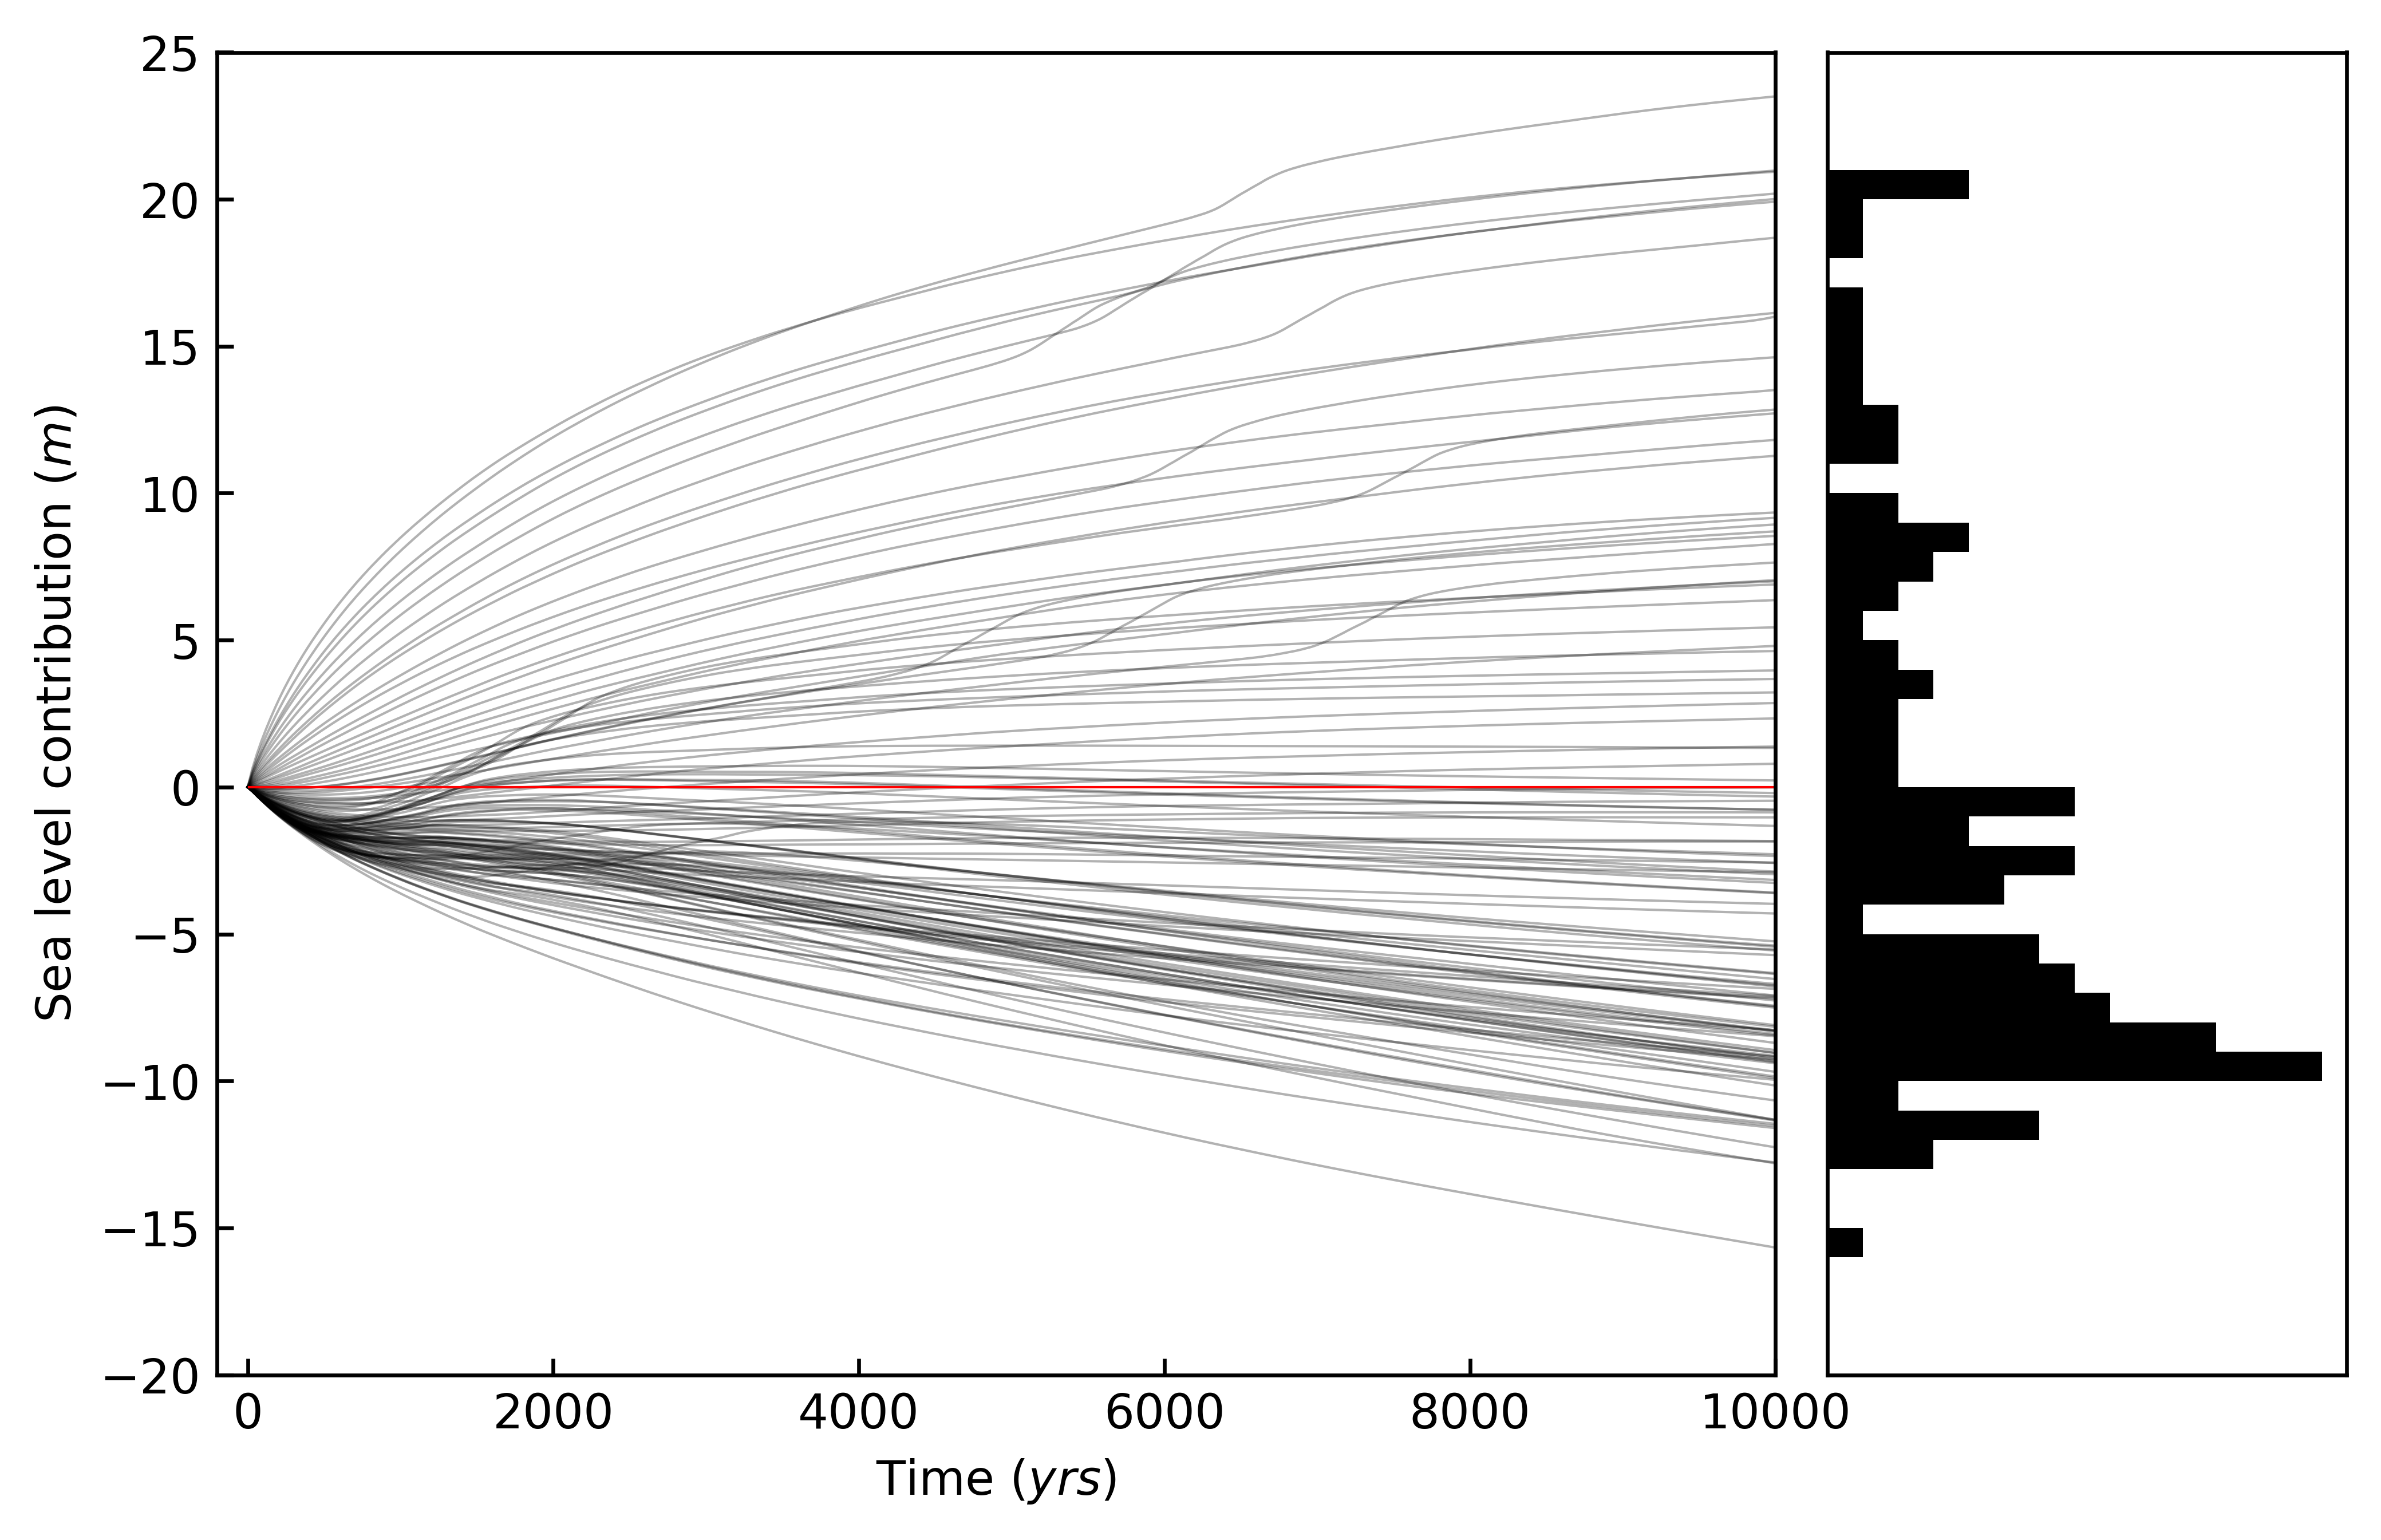

In [3]:
fig = cplot.ts_with_hist(
    df,
    color='black',
    lw=0.5,
    ylabel='Sea level contribution ($m$)',
    ylim = (-20, 25),
    alpha=0.3
    )

## Extrapolated Timeseries

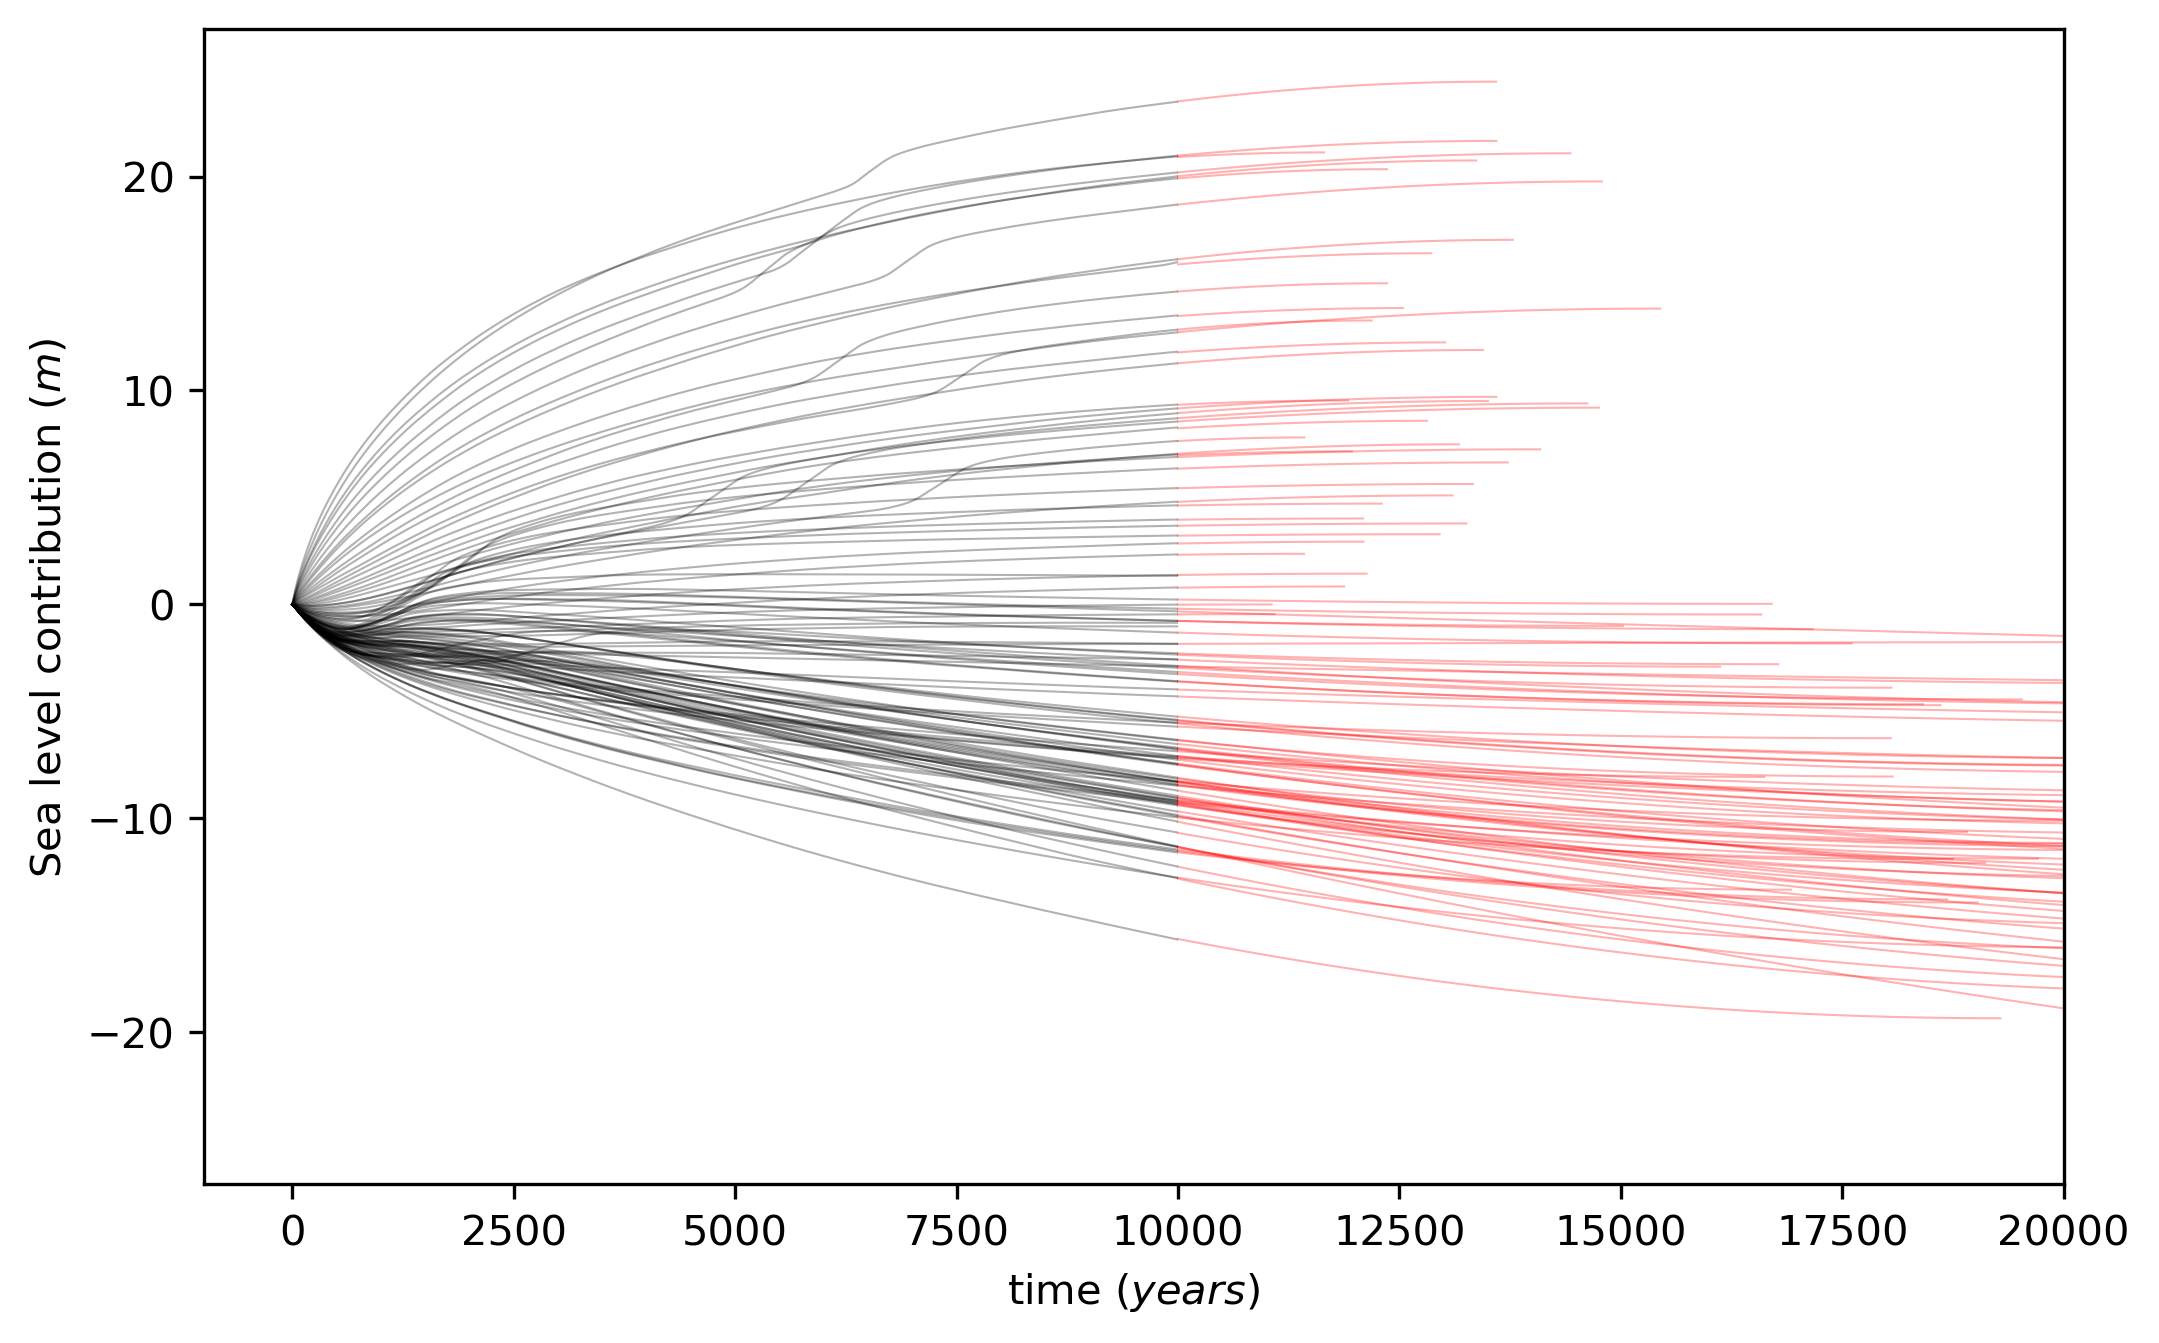

In [11]:
fig, ax = mpl.pyplot.subplots(figsize=(8, 5), dpi=300)

years = np.arange(0, 10020, 30)

def quadratic(x, a, b, c):
    return a*(x-b)**2 + c

def asymptotic(x, a, b, n):
    return a * x ** n  / (x ** n + b)

for i, run_num in enumerate(df):
    run = df[run_num]
    ax.plot(years, run, c='black', alpha=0.3, lw=0.5)
    ax.set_ylabel('Sea level contribution ($m$)')
    ax.set_xlabel('Time ($years$)')

    if int(run_num) not in weird_runs:
        start_year=5000
    else:
        start_year=8000
    fit_years = np.arange(start_year, 9990, 30)
    fit_data = run[run.index > start_year]

    poly = np.polyfit(fit_years, fit_data, deg=2)
    a, b, c = poly
    end_year = -b/(2*a)
    if end_year < 10_000:
        continue

    #asymp, _ = curve_fit(asymptotic, fit_years, fit_data)

    years_extrap = np.linspace(10_000, end_year, 100)
    extrapolation = np.polyval(poly, years_extrap)

    ax.plot(years_extrap, extrapolation, c='red', alpha=0.3, lw=0.5)
    ax.set_xlim([-1000, 20000])

    #popt, pcov = curve_fit(asymptotic, fit_years, fit_data, p0=[1., 5000., 1.])

    fig.savefig('plots/png/control_ensemble_extrap.png', format='png')

## Equilibrium vs Transient

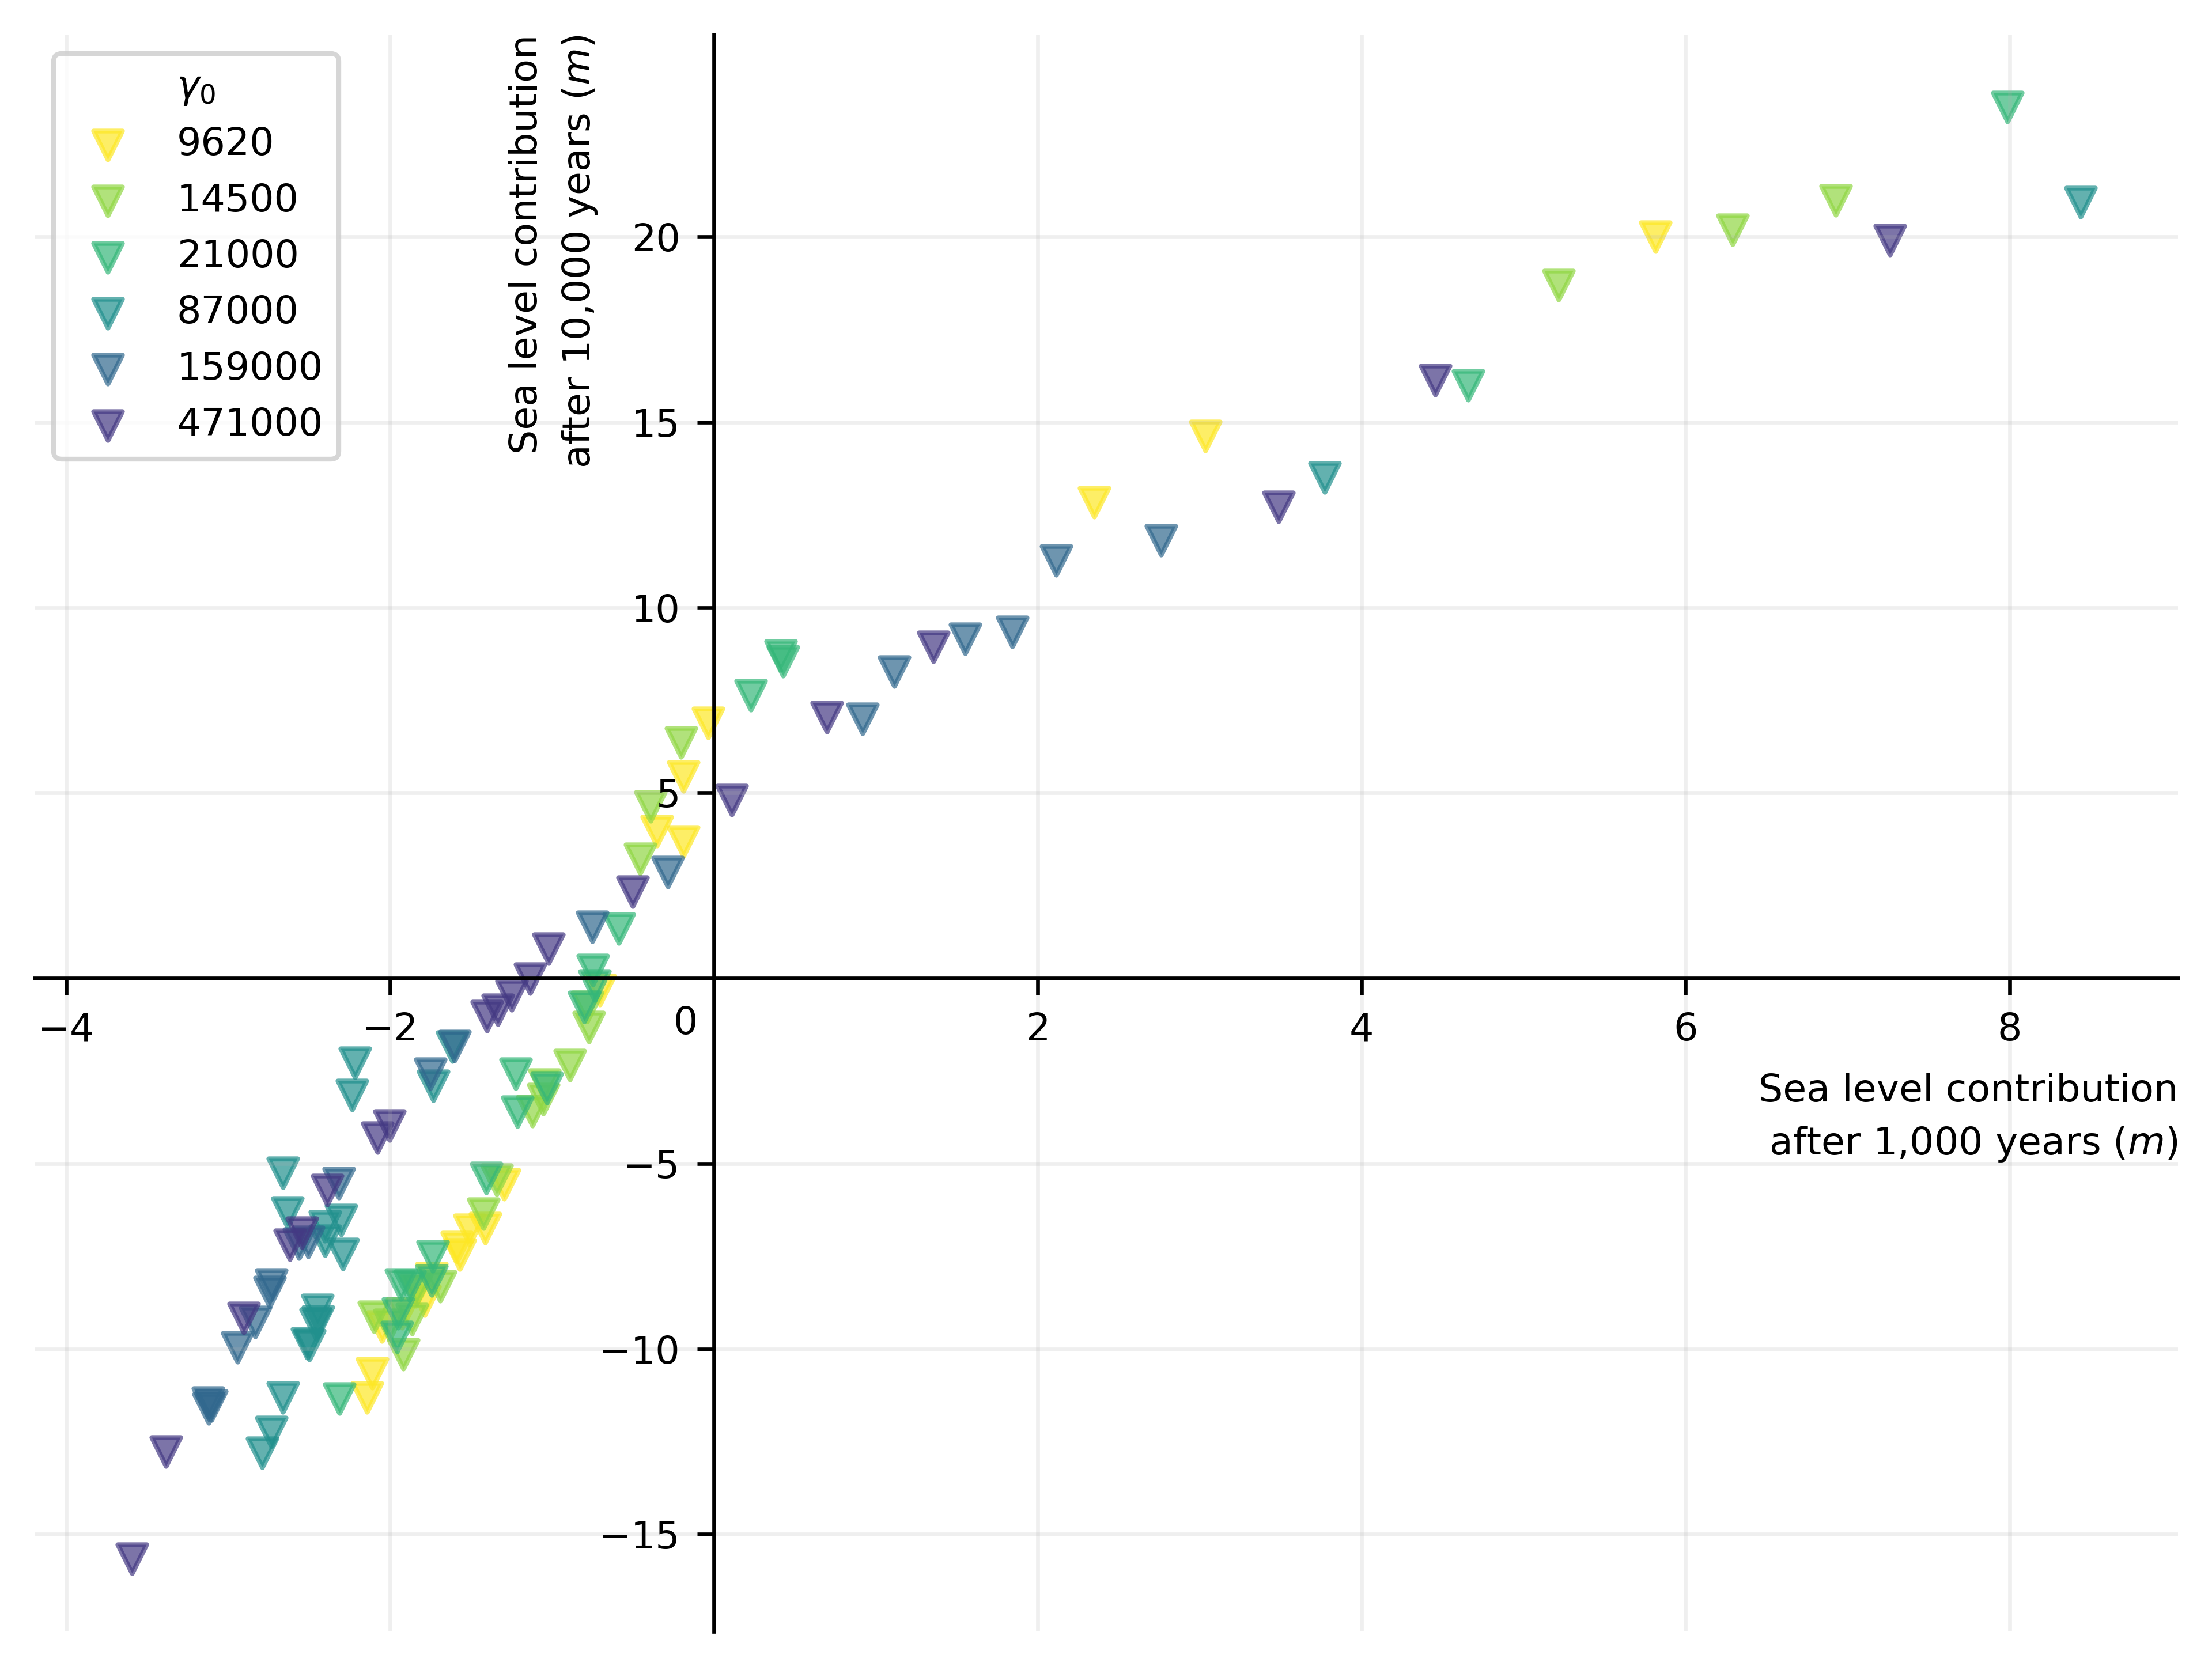

In [13]:
font = {'size': 8}
mpl.rc('font', **font)

fig, ax = mpl.pyplot.subplots(figsize=(8, 6), dpi=600)

unique_gamma_values = sorted(ppe['gamma0'].unique())
colors = mpl.cm.viridis_r([i / len(unique_gamma_values) for i in range(len(unique_gamma_values))])
gamma_color_map = {gamma_value: colors[i] for i, gamma_value in enumerate(unique_gamma_values)}

dft = df.T
dft.index=range(120)
for i, gamma_value in enumerate(unique_gamma_values):
    gamma_df = dft[ppe['gamma0'] == gamma_value]
    ax.scatter(
        gamma_df[990.0], 
        gamma_df[9990.0], 
        color=gamma_color_map[gamma_value], 
        label=f'{int(round_sig_figs(gamma_value, 3))}',
        marker='v',
        alpha=0.7
        )

for spine in ['top', 'right']:
    ax.spines[spine].set_color('none')
for spine in ['left', 'bottom']:
    ax.spines[spine].set_position('zero')

ax.grid(alpha=0.2)
legend = ax.legend(title='$\gamma_0$', loc='upper left')
ax.set_xticks([-4, -2, 2, 4, 6, 8])
ax.set_yticks([-15, -10, -5, 5, 10, 15, 20])

ax.set_xlabel('Sea level contribution\n after 1,000 years ($m$)', loc='right', labelpad=5, linespacing=1.5)
ax.set_ylabel('Sea level contribution\n after 10,000 years ($m$)', loc='top', labelpad=0, linespacing=1.5)
ax.text(-0.25, -1.5, '0')

mpl.pyplot.savefig('plots/svg/transientVsequilibrium.svg', format='svg')
mpl.pyplot.savefig('plots/png/transientVsequilibrium.png', format='png')

## Sensitivity

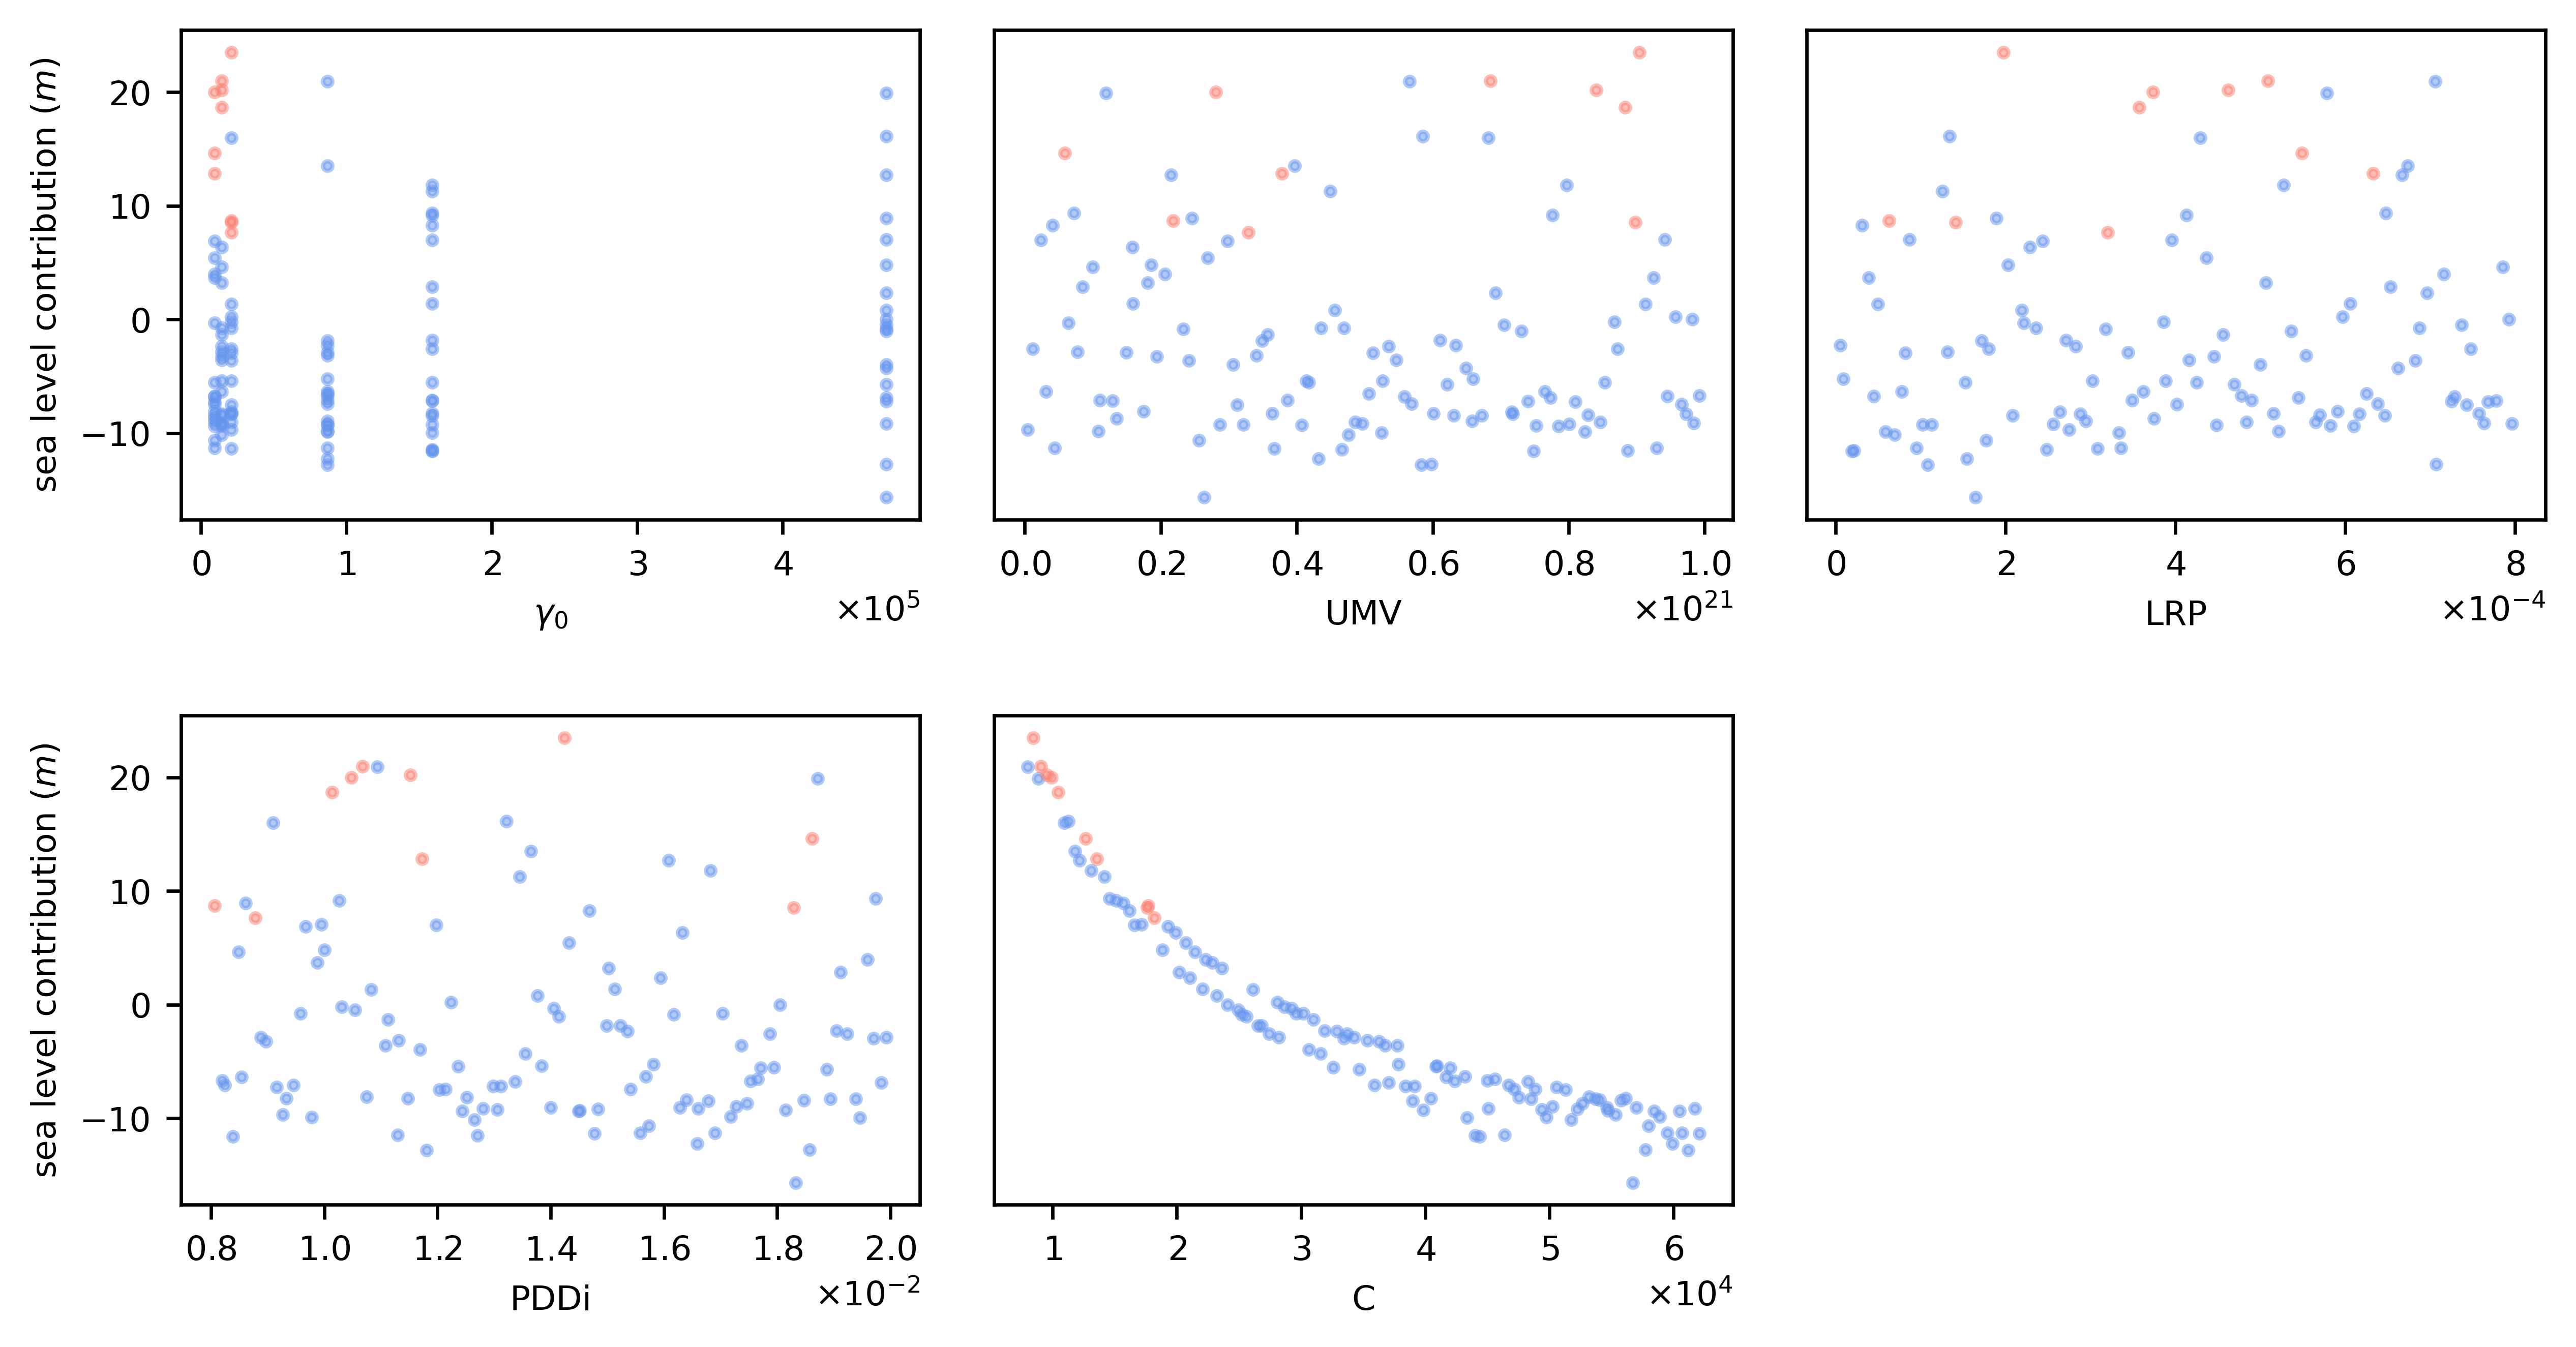

In [7]:
font = {'size': 8}
mpl.rc('font', **font)

parameters = ['gamma0', 'UMV', 'LRP', 'PDDi', 'WeertC']
relabel = {
    'gamma0': '$\gamma_0$',
    'WeertC': 'C'
}
slc.index = range(1, 121)
mask = slc.index.isin(weird_runs)
cplot.sensitivity(ppe[parameters], slc, mask=mask, relabel=relabel, colors=['cornflowerblue', 'salmon'], s=5, alpha=0.5)

mpl.pyplot.savefig('plots/svg/sensitivity_main.svg', format='svg')
mpl.pyplot.savefig('plots/png/sensitivity_main.png', format='png')

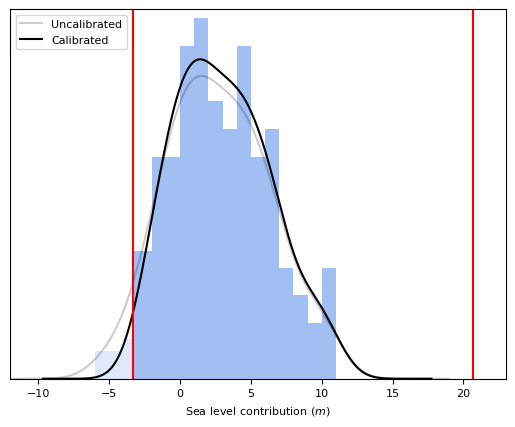

In [9]:
fig, ax = mpl.pyplot.subplots()

summary = pd.read_csv('data/pliocene_summary.csv')

bins=np.linspace(-3.3, 20.7, 20)
diff = bins[1]-bins[0]
new_min_bin = bins[0]-3*diff

bins = np.arange(new_min_bin, 20.7+diff, diff)
bins = [-17, -16, -15, -14, -13, -12, -11, -10, -9, -8, -7, -6, -5, -4, -3.3, -2, -1, 0, 1, 2, 3, 4,\
         5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 20.7, 22, 23, 24, 25, 26, 27, 28]
n, bins, patches = ax.hist(summary['Plio_minus_ctrl'], bins=bins, density=True, alpha=0.6)

# Set alpha conditionally for bars with x coordinate less than -3
for i in range(len(bins)-1):
    if bins[i] < -3.3:
        patches[i].set_alpha(0.2)

summary['Plio_minus_ctrl'].plot.kde(color='black', label='Uncalibrated', alpha=0.2)
summary[summary['Plio_minus_ctrl']>-3]['Plio_minus_ctrl'].plot.kde(color='black', label='Calibrated')

ax.legend(loc = 'upper left')
ax.get_yaxis().set_visible(False)
ax.set_xlim(-12, 23)
ax.set_ylim(0, 0.12)

ax.vlines(-3.3, 0, 0.12, color='red')
ax.vlines(20.7, 0, 0.12, color='red')

ax.set_xlabel('Sea level contribution ($m$)')

mpl.pyplot.savefig('plots/svg/pliominusctrl.svg', format='svg')
mpl.pyplot.savefig('plots/png/pliominusctrl.png', format='png')

In [10]:
min = summary['Plio_minus_ctrl'].min()
max = summary['Plio_minus_ctrl'].max()
mean = summary['Plio_minus_ctrl'].mean()
sdt = summary['Plio_minus_ctrl'].std()
median = summary['Plio_minus_ctrl'].median()

print(min, max, mean, sdt, median, sep='\n')

-5.355443268738638
10.885869710873497
2.71590846284614
3.571899640666879
2.4764756131523136


In [11]:
np.sum(summary['Plio_minus_ctrl']>-3.3)

108

In [12]:
mask = summary['Plio_minus_ctrl']>-3.3
calibrated = summary['Plio_minus_ctrl'][mask]
print(calibrated.mean())
print(calibrated.std())
print(calibrated.median())

2.9227975872669485
3.3921051038233396
2.5799646521224275
